In [ ]:
!pip install finance-DataReader
!pip install pykrx 

     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 51 kB 456 kB/s 
     |████████████████████████████████| 251 kB 37.6 MB/s 


In [ ]:
import pandas as pd
import requests
import re
import time
import random
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr 
from datetime import timedelta
from datetime import datetime

import pandas as pd
import requests
import re
import time
import random
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr 
from datetime import timedelta
from datetime import datetime
import requests 
from bs4 import BeautifulSoup 
import urllib.request as r
from pykrx import stock

No Korean fonts found. Please install the font shown belowbecause Hangul can be broken on the chart.
 - NanumBarunGothic font is required.

    1) font install

    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    2) runtime restart if colab
    
PYKRX works fine regardless of font installation.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc7a9e99d10>,
                     Sum  First_Balance   Sum_CAGR    Sum_MDD  Sharp_Ratio
 2021-12-30  2134.444325           1000  20.870747  34.712176     0.725889)

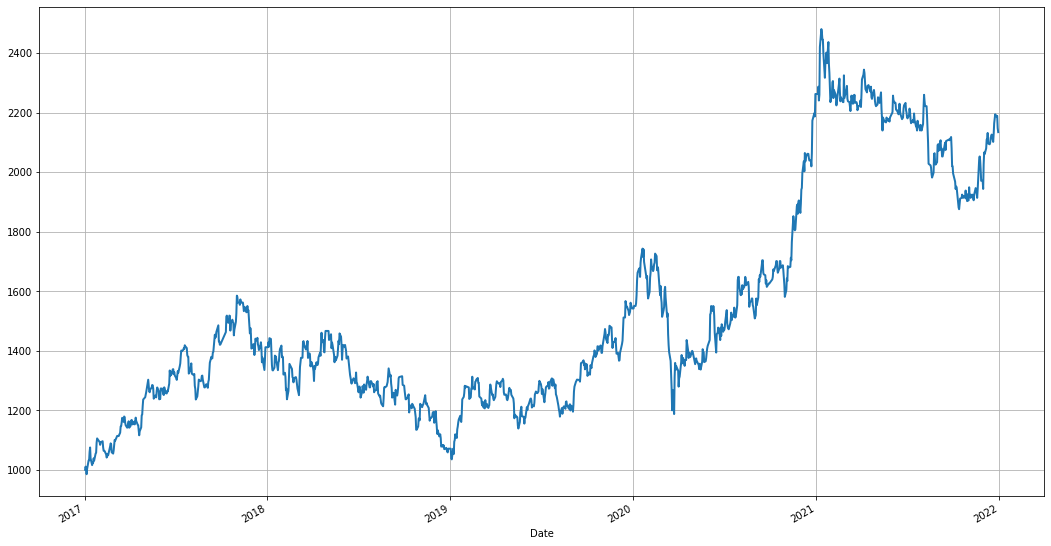

In [ ]:
# 차트설정
%matplotlib inline
plt.rc('font', family='NanumSquare')
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True


#### 개별 종목 함수 만들기
def single_result(first_balance, code, rate, buy_date, end_date):
    single_etf = pd.DataFrame(fdr.DataReader(code, buy_date, end_date)['Close'])

    ## 각 칼럼 생성
    single_etf['Rate'] = 0  # 첫 수익률은 0라 생각하고 시작
    single_etf[code] = first_balance * rate  # 첫 행의 보유 금액 = 처음 자산 * 자산배분비율

    #### 수익률, 평가금액 구하는 법
    for x in range(1, len(single_etf)):
        # 각 행의 수익률 = (현재 가격 - 이전 가격)/이전가격 * 100
        single_etf['Rate'].iloc[x] = ((single_etf['Close'].iloc[x] - single_etf['Close'].iloc[x - 1]) /
                                      single_etf['Close'].iloc[x - 1]) * 100

        # 첫 행의 보유 금액은 자산 배분 비율에 따라 달라짐
        # 평가금액 = 이전 평가금액 * (1+(수익률)/100)
        single_etf[code].iloc[x] = single_etf[code].iloc[x - 1] * (1 + (single_etf['Rate'].iloc[x] / 100))

    return single_etf


#### 포트폴리오(합산) 함수 만들기
def port_result(first_balance, code_list, rate_list, buy_date, end_date):
    ## 포트폴리오 데이터프레임의 인덱스, 칼럼 생성
    multi_df = pd.DataFrame(
        index=fdr.DataReader(str(code_list[0]), buy_date, end_date).index)  # 빈 프레임값의 인덱스를 미리 0번째 etf의 인덱스로 지정
    multi_df['Sum'] = 0  # 첫 행 임의 지정

    ## 포트폴리오의 모든 종목 돌려서 투자 비율 반영된 각 종목 Balance 값 만들기
    for x in range(0, len(code_list)):
        code_name = code_list[x]  # 각 코드명 = 각 코드 리스트 자리 값
        each_rate = rate_list[x]  # 각 비율 = 각 비율 리스트 자리 값
        single_df = single_result(first_balance, code_name, each_rate, buy_date, end_date)

        single_balance_df = pd.DataFrame(single_df[code_name])  # 위의 칼럼만 데이터프레임화 해서 가져올 것
        multi_df = pd.merge(multi_df, single_balance_df, left_index=True, right_index=True,
                            how='left')  # 인덱스 값이 같다면 이어서 Merge 합치기

    ## 포트폴리오 모든 종목의 합산 값 구하기
    for y in range(0, len(multi_df)):
        multi_df['Sum'].iloc[y] = sum(multi_df.iloc[y])

    multi_df = multi_df.dropna(axis=0)

    #### 리밸런싱까지 완료된 후에 각 행의 수익률/CAGR/DD/MDD/Sharp Ratio 구하기

    return multi_df


#### Rate/CAGR/DD/MDD 구하는 함수
def var_result(result_df):
    result_df['Sum_Rate'] = 0  # 합산 금액의 수익률
    result_df['Sum_CAGR'] = 0  # 합산 금액의 평균 복리
    result_df['Sum_DD'] = 0  # 합산 금액의 Draw Down
    result_df['Sum_MDD'] = 0  # 합산 금액의 Max Draw Down

    for z in range(1, len(result_df)):

        # 각 행의 수익률 = (현재 가격 - 이전 가격)/이전가격 * 100
        result_df['Sum_Rate'].iloc[z] = ((result_df['Sum'].iloc[z] - result_df['Sum'].iloc[z - 1]) /
                                         result_df['Sum'].iloc[z - 1]) * 100

        # CAGR 구하기
        if (int(result_df.index[z].year)) == (int(result_df.index[0].year)):  # 1년차의 경우 수익률 값과 동일하게 진행
            result_df['Sum_CAGR'].iloc[z] = result_df['Sum_Rate'].iloc[z]

        # CAGR 공식 = [마지막년도 수치 / 첫년도 수치] ^[1/n] - 1
        else:
            result_df['Sum_CAGR'].iloc[z] = ((result_df['Sum'].iloc[z] / result_df['Sum'].iloc[0]) ** (
                        1 / (result_df.index[z].year - result_df.index[0].year)) - 1) * 100

        # 각 행의 DD = (1- 현재가/현재까지의가격중 최대가) * 100
        result_df['Sum_DD'].iloc[z] = (1 - (result_df['Sum'].iloc[z] / result_df['Sum'].iloc[:z].max())) * 100

        # MDD = 여태까지의 DD중 가장 큰 값
        result_df['Sum_MDD'].iloc[z] = result_df['Sum_DD'].iloc[:z].max()

    return result_df


#### 리밸런싱 함수 만들기
def rebalance(first_balance_, code_list_, rate_list_, buy_date, end_date):
    code_list = code_list_  # 포트폴리오 리스트
    rate_list = rate_list_  # 비율 리스트
    first_balance = first_balance_  # 첫 금액
    start_date = buy_date  # 구매일
    end_date = end_date  # 매도일
    start_year = datetime.strptime(start_date, "%Y-%m-%d").year  # 구매 년도 계산 -> 문자열을 시계열로
    end_year = datetime.strptime(end_date, "%Y-%m-%d").year  # 매도 년도 계산 -> 문자열을 시계열로

    # 1) 매도와 매수 차이가 1년보다 작을 경우 -> 그대로 포트폴리오 합산 함수 사용
    if (end_year - start_year) < 1:
        merged_df = port_result(first_balance, code_list, rate_list, start_date, end_date)

    # 2) 매도와 매수 차이가 1년보다 클 경우 -> 매년 1년 차마다 리밸런싱
    else:
        merged_df = port_result(first_balance, code_list, rate_list, start_date,
                                datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=364))  # 1년차 먼저 계산

        # 2-1) 합친 데이터프레임의 시계열 가장 마지막 날짜가 매도일자보다 작을 경우
        if merged_df.index[-1] < \
                fdr.DataReader(code_list[0], datetime.strptime(end_date, "%Y-%m-%d") - timedelta(7), end_date).index[
                    -1]:
            for year_gap in range(1, int(end_year - start_year)):  # 연차마다 돌려주기

                balance = merged_df['Sum'].iloc[-1]  # 첫 Balance 금액 = 이미 합친 마지막 Balance 값
                year = timedelta(days=365 * year_gap)  # 변수 = 더 해줄 리밸런싱 차이
                start = datetime.strptime(start_date, "%Y-%m-%d") + year  # 매수일자 = 매수 일자 + 리밸런싱 차이 값(1년, 2년, 3년...)
                last = start + timedelta(days=364)  # 매도 일자 = 매수일자 + 364

                start_day = str(start)  # 매수 일자 시계열 값 -> 문자열 값
                # 2-1-1) 매도 일자가 최종 매도일보다 작은 경우 -> 그대로 매도 일자 지정
                if last < datetime.strptime(end_date, "%Y-%m-%d"):
                    last_day = str(last)
                # 2-1-2) 매도 일자가 최종 매도일보다 큰 경우 -> 매도 일자 = 최종 매도일
                else:
                    last_day = str(datetime.strptime(end_date, "%Y-%m-%d"))

                first_result = port_result(balance, code_list, rate_list, start_day, last_day)  # 첫 포트폴리오 함수 값
                merged_df = pd.concat([merged_df, first_result])  # 이어 붙여나가기


        # 2-2) 합친 데이터프레임의 시계열 가장 마지막 날짜가 매도일자보다 큰 경우 Pass
        else:
            pass

    final_df = var_result(merged_df)

    return final_df


#### 그래프 나타내는 함수
def show_graph(df, first_balance):  # 최종 결과 함수값과 최초 투자금액 입력
    show_df = pd.DataFrame(df.iloc[-1]).transpose()  # 최종결과 값의 마지막 값만 데이터프레임화
    show_df['First_Balance'] = first_balance  # 최초 금액 입력
    show_df['Sharp_Ratio'] = df['Sum_Rate'].mean() / df['Sum_Rate'].std() * (252 ** 0.5)  # Sharp Ratio 공식 넣어줄 것
    show_df = show_df[
        ['Sum', 'First_Balance', 'Sum_CAGR', 'Sum_MDD', 'Sharp_Ratio']]  # 최종 금액, 최초 투자 금액, CAGR, MDD, 샤프지수

    return df['Sum'].plot(), show_df  # 보유금액의 변동 그래프 값도 내보내기


#### 각 자산군의 상관관계 나타내는 함수
def pearson(df):
    pearson_df = df[code_list_]

    return pearson_df.corr(method='pearson')


#### 테스트
code_list_ = ['005930'] # 포트폴리오 리스트
rate_list_ = [1] # 비율 리스트
first_balance_ = 1000
buy_date = '2017-01-01'
end_date = '2022-05-16'

A = rebalance(first_balance_, code_list_, rate_list_, buy_date, end_date)

pearson(A)
show_graph(A, first_balance_)

In [ ]:
# 오늘날 코스피에 상장되어 있는 주식의 이름과 티커 수집 
today = datetime.today().strftime("%Y%m%d") 
ticker_list = stock.get_market_ticker_list(date = today, market="KOSPI") 
symbol_list = [] 
for ticker in ticker_list: 
  symbol = stock.get_market_ticker_name(ticker) 
  symbol_list.append(symbol) 

# 코스피 상장 주식의 개수 확인 
print(len(ticker_list)) 
print(len(symbol_list))

940
940


In [ ]:
df_우 = [s for s in symbol_list if s.endswith('우') | s.endswith('우B') | s.endswith('우(전환)')]
res = [i for i in symbol_list if i not in df_우]

ticker = pd.DataFrame(ticker_list)
symbol = pd.DataFrame(symbol_list)
sol = pd.concat([ticker, symbol], axis=1)
sol.columns= ['종목코드', '종목명']
kospi_df = sol[sol['종목명'].isin(res)]
kospi_df.reset_index(inplace=True)
kospi_df.drop('index', axis=1, inplace=True)
kospi_df['종목코드'] = kospi_df['종목코드'].astype('str')
ticker_ks = kospi_df['종목코드'].tolist()
print(len(ticker_ks))
kospi_df

820


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,종목코드,종목명
0,095570,AJ네트웍스
1,006840,AK홀딩스
2,027410,BGF
3,282330,BGF리테일
4,138930,BNK금융지주
...,...,...
815,005870,휴니드
816,079980,휴비스
817,005010,휴스틸
818,000540,흥국화재


In [ ]:
class Company:
    def __init__(self, Name, Code):
        self.Name = Name
        self.Code = Code
        self.LoadStockSummary(Code)

    def LoadStockSummary(self, ticker):
        url = "http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&gicode=A" + ticker + "&cID=&MenuYn=Y&ReportGB=&NewMenuID=Y&stkGb=701"
        response = r.urlopen(url)
        soup = BeautifulSoup(response, 'html.parser')

        # get PER PBR ROE
        tmp = soup.find('div', {'class': 'corp_group2'})
        tmp2 = tmp.findAll('dd')
        self.PER = tmp2[1].contents
        self.PER12M = tmp2[3].contents
        self.PERIndustry = tmp2[5].contents
        self.PBR = tmp2[7].contents
        self.DividendRatio = tmp2[9].contents

        # get Summary
        for anchor in soup.select(".um_bssummary"):
            pass
        self.Summary = anchor.get_text()

    def print_info(self):
        print("Name: ", self.Name)
        print("Code: ", self.Code)
        print("Summary: ", self.Summary)
        print("PER: ", self.PER)
        print("PER12M: ", self.PER12M)
        print("PERIndustry: ", self.PERIndustry)
        print("PBR: ", self.PBR)
        print("DividendRatio: ", self.DividendRatio)


def run():

    Name = "삼성전자"
    Code = "005930"
    company = Company(Name, Code)
    company.print_info()


if __name__ == "__main__":
    run()

Name:  삼성전자
Code:  005930
Summary:  
고부가제품 비중확대로 최대 실적 경신

한국 및 CE, IM부문 해외 9개 지역총괄과 DS부문 해외 5개 지역총괄, Harman 등 234개의 종속기업으로 구성된 글로벌 전자기업임. 세트사업에는 TV, 냉장고 등을 생산하는 CE부문과 스마트폰, 네트워크시스템, 컴퓨터 등을 생산하는 IM부문이 있음. 부품사업(DS부문)에서는 D램, 낸드 플래쉬, 모바일AP 등의 제품을 생산하는 반도체 사업과 TFT-LCD 및 OLED 디스플레이 패널을 생산하는 DP사업으로 구성됨.2021년 Neo QLED TV, 비스포크 등 프리미엄 제품과 플래그십 휴대폰, 고용량 메모리와 OLED 패널 등의 판매확대로 사상최대 실적을 경신함. IM부문은 코로나19의 장기화, 부품공급 부족사태 등에도 불구하고 프리미엄 제품 비중 확대와 운영효율 제고를 통해 매출과 영업이익 모두 성장하는견조한 실적. 반도체사업은 서버 및 모바일용 고용량 제품 등 부품수요 증가로 매출액은 전년 대비 29.2%, 영업이익은 55.3% 늘어남.


PER:  ['11.77']
PER12M:  ['9.44']
PERIndustry:  ['12.94']
PBR:  ['1.56']
DividendRatio:  ['2.12%']
